### Baseline

In [1]:
import torch

print(torch.__version__)

2.6.0+cpu


In [6]:
# For kaggle GPU
from pathlib import Path

!pip install -q flashlight-text

DATA_DIR = Path("/kaggle/input/morse-to-chars/")
AUDIO_FILES_DIR = DATA_DIR / "morse_dataset"
MODELS_DIR = Path("/kaggle/output/models")
SEED = 777

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.0 MB/s eta 0:00:00


In [1]:
from typing import Callable, Optional, Tuple, Dict, Union, List

import librosa
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchaudio
from torchaudio.functional import edit_distance
from torchaudio.models.decoder import ctc_decoder
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
import os
import sys
from pathlib import Path

import IPython
import librosa.display as ld
import matplotlib.pyplot as plt


In [2]:
sys.path.append("../src")

from config import DATA_DIR, AUDIO_FILES_DIR, SEED, MODELS_DIR

np.random.seed(SEED)


In [3]:
np.random.seed(SEED)
AUDIO_FILES_DIR

WindowsPath('C:/Users/user/Desktop/Jupyter_and_projects/test_kontur/morse_decoder/data/raw/morse_dataset')

### ex

In [17]:
sample = np.random.randint(low=0, high=30000, size=3)
sample_train = data["train"].iloc[sample]
sample_train

NameError: name 'data' is not defined

In [ ]:
%%time
vocab = {0: "<blk>", 1: "|"}
all = set()
for i in sample_train.message:
    all = all.union(list(i))

print(all)

for i, j in enumerate(all):
    vocab[i + 2] = j
print(vocab)

{'Й', 'С', 'И', 'З', 'Е', '8', ' ', 'Л', 'М', 'Ы', 'Д', 'Ц', 'Ь', 'Н', 'Щ', 'Р', 'Г', 'Ф', '#', 'А', '4'}
{0: '<blk>', 1: '|', 2: 'Й', 3: 'С', 4: 'И', 5: 'З', 6: 'Е', 7: '8', 8: ' ', 9: 'Л', 10: 'М', 11: 'Ы', 12: 'Д', 13: 'Ц', 14: 'Ь', 15: 'Н', 16: 'Щ', 17: 'Р', 18: 'Г', 19: 'Ф', 20: '#', 21: 'А', 22: '4'}
CPU times: total: 0 ns
Wall time: 997 μs


In [ ]:
tokenizer = Tokenizer(vocab=vocab)


In [ ]:
dataset = MorseDataset(
    X_filenames=sample_train.id,
    y_texts=sample_train.message,
    transform=path_to_melspect,
    tokenizer=tokenizer,
)

In [ ]:
loader = data_loader(dataset, batch_size=2, shuffle=True, drop_last=True)

In [ ]:
for batch in loader:
    print(model(batch["input"]).shape)
    print(batch["target_text"])

(176400,)
(80, 345)
(176400,)
(80, 345)
torch.Size([2, 128, 173])
torch.Size([2, 128, 173])
torch.Size([2, 128, 171])
torch.Size([2, 171, 256])
torch.Size([2, 171, 128])
torch.Size([2, 171, 23])
['З ЙГ#48ГЛ', 'РМНИЫ8ЦФ']


In [ ]:
model = ModelBase(
    input_size=[80, 345], kernel_chanel=128, conv_out_size=128, vocab_size=len(vocab)
)
model

ModelBase(
  (conv_part): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(80, 128, kernel_size=(5,), stride=(2,), padding=(2,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (2): ConvBlock(
      (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
  )
  (rnn_part): Sequential(
    (0): LstmBlock(
      (lstm): LSTM(128, 128, num_layers=2, batch_first=True, bidirectional=True)
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.2, inplace=False)
    )
    (1): LstmBlock(
      (lstm): LSTM(256, 64, num_layers=2, batch_first=True, bidirectional=True)
      (norm): LayerNorm((128,), eps=1e-05, elementwise_

In [ ]:
log_probs = torch.full((15, 2, len(vocab)), fill_value=-float("inf"))

blank_idx = 0  #
Б = tokenizer.char_index["Б"]
Я = tokenizer.char_index["Я"]
Х = tokenizer.char_index["Х"]
space = tokenizer.char_index[" "]

#
log_probs[0, 0, Б] = 1.0
log_probs[1, 0, blank_idx] = 1.0
log_probs[2, 0, Я] = 1.0
log_probs[3, 0, blank_idx] = 1.0
log_probs[4, 0, Х] = 1.0
log_probs[5:, 0, blank_idx] = 1.0

log_probs[0, 1, Я] = 1.0
log_probs[1, 1, blank_idx] = 1.0
log_probs[2, 1, space] = 1.0
log_probs[3, 1, blank_idx] = 1.0
log_probs[4, 1, Б] = 1.0
log_probs[5:, 1, blank_idx] = 1.0

print(log_probs.shape)
log_probs = log_probs.transpose(0, 1)
print(log_probs.shape)
results = bim_search_decoder(log_probs.contiguous())  # log_probs: [B, T, C]
decoded_sequences = []
for batch_result in results:  #  это список гипотез
    top_hypo = batch_result[0]
    tokens = top_hypo.tokens.tolist()
    decoded_sequence = tokenizer.decode(tokens)
    decoded_sequence = decoded_sequence.strip("|")
    decoded_sequences.append(decoded_sequence)

print(decoded_sequences)  # → ['БЯХ']


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model, metrics = train_model(
    model=model,
    train_loader=loader,
    optimizer=optimizer,
    ctc_loss=loss_ctc,
    epochs=2,
    metric=edit_distance,
    decoder=bim_search_decoder,
    tokenizer=tokenizer,
)

Using device: cpu


Epoch:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s]

(176400,)
(80, 345)
(176400,)
(80, 345)
torch.Size([2, 128, 173])
torch.Size([2, 128, 173])
torch.Size([2, 128, 171])
torch.Size([2, 171, 256])
torch.Size([2, 171, 128])
Epoch 1 with loss = 7.5531 and metric_train=8.5000


(176400,)


Epoch: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

(80, 345)
(176400,)
(80, 345)
torch.Size([2, 128, 173])
torch.Size([2, 128, 173])
torch.Size([2, 128, 171])
torch.Size([2, 171, 256])
torch.Size([2, 171, 128])
Epoch 2 with loss = 4.6699 and metric_train=10.0000


### load and divide

In [158]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [159]:
def load_files(folder_path):
    variables = {}

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        if file_name.endswith(".csv"):
            var_name = os.path.splitext(file_name)[0]
            variables[var_name] = pd.read_csv(file_path)
            print(f"{var_name} downloaded")

    return variables

In [160]:
# kaggle
data = load_files(DATA_DIR)

In [161]:
# local file
data = load_files(DATA_DIR.joinpath("raw"))

test downloaded
train downloaded


In [162]:
X_train, X_val, y_train, y_val = train_test_split(
    data["train"]["id"], data["train"]["message"], test_size=0.15, random_state=SEED
)
for df in [X_train, y_train, X_val, y_val]:
    print(len(df))

25500
25500
4500
4500


In [163]:
full_vocab = get_vocab(data["train"]["message"])

Vocab is ready, size = 46


In [164]:
tokens = list(full_vocab.values())
print(tokens[0])

<blk>


In [165]:
bim_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=list(full_vocab.values()),
    beam_size=3,
    nbest=1,
    blank_token="<blk>",
)

In [166]:
from functools import partial

In [167]:
tokenizer = Tokenizer(vocab=full_vocab)

print(tokenizer.index_char)
print(tokenizer.char_index)

transform = partial(
    path_to_melspect_cached,
    audio_files_dir=AUDIO_FILES_DIR,
    cache_dir=Path("./mels_cache"),
)

tain_dataset = MorseDataset(
    X_filenames=X_train,
    y_texts=y_train,
    transform=transform,
    tokenizer=tokenizer,
)

train_loader = data_loader(
    tain_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0
)

val_dataset = MorseDataset(
    X_filenames=X_val, y_texts=y_val, transform=transform, tokenizer=tokenizer
)
val_loader = data_loader(
    val_dataset, batch_size=64, shuffle=False, drop_last=True, num_workers=0
)

{0: '<blk>', 1: '|', 2: ' ', 3: '#', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: 'А', 15: 'Б', 16: 'В', 17: 'Г', 18: 'Д', 19: 'Е', 20: 'Ж', 21: 'З', 22: 'И', 23: 'Й', 24: 'К', 25: 'Л', 26: 'М', 27: 'Н', 28: 'О', 29: 'П', 30: 'Р', 31: 'С', 32: 'Т', 33: 'У', 34: 'Ф', 35: 'Х', 36: 'Ц', 37: 'Ч', 38: 'Ш', 39: 'Щ', 40: 'Ъ', 41: 'Ы', 42: 'Ь', 43: 'Э', 44: 'Ю', 45: 'Я'}
{'<blk>': 0, '|': 1, ' ': 2, '#': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, 'А': 14, 'Б': 15, 'В': 16, 'Г': 17, 'Д': 18, 'Е': 19, 'Ж': 20, 'З': 21, 'И': 22, 'Й': 23, 'К': 24, 'Л': 25, 'М': 26, 'Н': 27, 'О': 28, 'П': 29, 'Р': 30, 'С': 31, 'Т': 32, 'У': 33, 'Ф': 34, 'Х': 35, 'Ц': 36, 'Ч': 37, 'Ш': 38, 'Щ': 39, 'Ъ': 40, 'Ы': 41, 'Ь': 42, 'Э': 43, 'Ю': 44, 'Я': 45}


In [176]:
tokenizer(list(val_loader.dataset.y_texts[:3]))

[[12, 28, 32, 16, 32, 42, 12, 2, 31, 25],
 [16, 17, 31, 41, 41, 18, 11, 24, 12],
 [9, 9, 45, 32, 43, 11, 43, 19, 38, 2, 35, 22]]

In [177]:
list(val_loader.dataset.y_texts[:3])

['8ОТВТЬ8 СЛ', 'ВГСЫЫД7К8', '55ЯТЭ7ЭЕШ ХИ']

In [ ]:
import torch.nn.init as init


def init_weights(module):
    if isinstance(module, nn.Conv1d):
        init.kaiming_normal_(module.weight, nonlinearity="relu")
        if module.bias is not None:
            init.constant_(module.bias, 0)

    elif isinstance(module, nn.Linear):
        init.xavier_uniform_(module.weight)
        if module.bias is not None:
            init.constant_(module.bias, 0)

    elif isinstance(module, nn.LSTM):
        for name, param in module.named_parameters():
            if "weight_ih" in name:
                init.xavier_uniform_(param)
            elif "weight_hh" in name:
                init.orthogonal_(param)
            elif "bias" in name:
                init.constant_(param, 0)

    elif isinstance(module, nn.LayerNorm):
        if module.elementwise_affine:
            init.constant_(module.weight, 1.0)
            init.constant_(module.bias, 0.0)

In [179]:
base_model = ModelBase(
    input_size=[80, 345],
    kernel_chanel=128,
    conv_out_size=128,
    vocab_size=len(full_vocab),
)
base_model.apply(init_weights)

optimizer = torch.optim.Adam(base_model.parameters(), lr=0.01)

base_model


ModelBase(
  (conv_part): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(80, 128, kernel_size=(5,), stride=(2,), padding=(2,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
  )
  (rnn_part): Sequential(
    (0): LstmBlock(
      (lstm): LSTM(128, 64, num_layers=2, batch_first=True, bidirectional=True)
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.4, inplace=False)
    )
  )
  (clf): Linear(in_features=128, out_features=46, bias=True)
)

In [180]:
import gc

gc.collect()

6393

In [181]:
base_model, base_metrics = train_model(
    model=base_model,
    train_loader=train_loader,
    optimizer=optimizer,
    ctc_loss=loss_ctc,
    epochs=50,
    metric=edit_distance,
    decoder=bim_search_decoder,
    tokenizer=tokenizer,
    val_loader=val_loader,
)

Using device: cpu

 Epoch 1/50


Training: 100%|██████████| 398/398 [00:40<00:00,  9.72it/s]


avg max prob: 0.9332262873649597
Epoch 1 with loss = 4.2796


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : 
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><bl

Training: 100%|██████████| 398/398 [00:38<00:00, 10.23it/s]


avg max prob: 0.9291524887084961
Epoch 2 with loss = 4.0364


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : 
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><bl

Training: 100%|██████████| 398/398 [00:38<00:00, 10.22it/s]


avg max prob: 0.9306018948554993
Epoch 3 with loss = 4.0299


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : 
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><bl

Training: 100%|██████████| 398/398 [00:39<00:00, 10.14it/s]


avg max prob: 0.9326310157775879
Epoch 4 with loss = 4.0248


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : 
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><bl

Training: 100%|██████████| 398/398 [00:38<00:00, 10.33it/s]


avg max prob: 0.9312642812728882
Epoch 5 with loss = 4.0089


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : 
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><bl

Training: 100%|██████████| 398/398 [00:39<00:00, 10.11it/s]


avg max prob: 0.9281665086746216
Epoch 6 with loss = 3.9672


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : 
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><bl

Training: 100%|██████████| 398/398 [00:39<00:00,  9.96it/s]


avg max prob: 0.9534834623336792
Epoch 7 with loss = 3.3022


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ы<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Н<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЫНМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>0<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk

Training: 100%|██████████| 398/398 [00:39<00:00,  9.96it/s]


avg max prob: 0.9807456731796265
Epoch 8 with loss = 1.2467


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>66<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><blk><

Training: 100%|██████████| 398/398 [00:39<00:00, 10.05it/s]


avg max prob: 0.9856698513031006
Epoch 9 with loss = 0.8300


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:39<00:00, 10.02it/s]


avg max prob: 0.9853307604789734
Epoch 10 with loss = 0.7132


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><bl

Training: 100%|██████████| 398/398 [00:40<00:00,  9.91it/s]


avg max prob: 0.9862238764762878
Epoch 11 with loss = 0.6414


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:39<00:00, 10.09it/s]


avg max prob: 0.9894114136695862
Epoch 12 with loss = 0.6021


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:43<00:00,  9.22it/s]


avg max prob: 0.9856576323509216
Epoch 13 with loss = 0.5634


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:42<00:00,  9.43it/s]


avg max prob: 0.9893977642059326
Epoch 14 with loss = 0.5390


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>ЬЬ<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><blk><

Training: 100%|██████████| 398/398 [00:39<00:00, 10.04it/s]


avg max prob: 0.9902855157852173
Epoch 15 with loss = 0.5157


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>ЬЬ<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>66<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Е<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><blk><blk>

Training: 100%|██████████| 398/398 [00:39<00:00, 10.08it/s]


avg max prob: 0.9900328516960144
Epoch 16 with loss = 0.5021


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:40<00:00,  9.74it/s]


avg max prob: 0.9879820346832275
Epoch 17 with loss = 0.4872


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>66<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>ЖЖ<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><blk><blk>

Training: 100%|██████████| 398/398 [00:40<00:00,  9.75it/s]


avg max prob: 0.9902231693267822
Epoch 18 with loss = 0.4767


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:39<00:00, 10.16it/s]


avg max prob: 0.989101231098175
Epoch 19 with loss = 0.4634


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:41<00:00,  9.66it/s]


avg max prob: 0.9913408160209656
Epoch 20 with loss = 0.4584


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:41<00:00,  9.64it/s]


avg max prob: 0.9889351725578308
Epoch 21 with loss = 0.4555


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:40<00:00,  9.92it/s]


avg max prob: 0.9907636642456055
Epoch 22 with loss = 0.4448


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:40<00:00,  9.79it/s]


avg max prob: 0.9901168942451477
Epoch 23 with loss = 0.4403


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:40<00:00,  9.71it/s]


avg max prob: 0.9889225959777832
Epoch 24 with loss = 0.4310


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:40<00:00,  9.80it/s]


avg max prob: 0.9921495318412781
Epoch 25 with loss = 0.4247


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:43<00:00,  9.05it/s]


avg max prob: 0.9905211925506592
Epoch 26 with loss = 0.4221


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>ЬЬ<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><blk><

Training: 100%|██████████| 398/398 [00:40<00:00,  9.77it/s]


avg max prob: 0.988440752029419
Epoch 27 with loss = 0.4196


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Е<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:41<00:00,  9.65it/s]


avg max prob: 0.9923384785652161
Epoch 28 with loss = 0.4122


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:39<00:00, 10.04it/s]


avg max prob: 0.9926445484161377
Epoch 29 with loss = 0.4109


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>ФФ<blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><blk><

Training: 100%|██████████| 398/398 [00:40<00:00,  9.79it/s]


avg max prob: 0.9912828207015991
Epoch 30 with loss = 0.4013


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:44<00:00,  8.97it/s]


avg max prob: 0.9908928871154785
Epoch 31 with loss = 0.4033


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:46<00:00,  8.62it/s]


avg max prob: 0.9906858205795288
Epoch 32 with loss = 0.4015


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:44<00:00,  9.02it/s]


avg max prob: 0.9943718910217285
Epoch 33 with loss = 0.3890


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>ЦЦ<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><blk><

Training: 100%|██████████| 398/398 [00:43<00:00,  9.11it/s]


avg max prob: 0.9903482794761658
Epoch 34 with loss = 0.3939


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:43<00:00,  9.05it/s]


avg max prob: 0.9918296933174133
Epoch 35 with loss = 0.3849


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>ЖЖ<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><blk> 

Training: 100%|██████████| 398/398 [00:43<00:00,  9.08it/s]


avg max prob: 0.9895620346069336
Epoch 36 with loss = 0.3765


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:43<00:00,  9.13it/s]


avg max prob: 0.9919819235801697
Epoch 37 with loss = 0.3802


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:43<00:00,  9.07it/s]


avg max prob: 0.9912022352218628
Epoch 38 with loss = 0.3820


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:44<00:00,  8.86it/s]


avg max prob: 0.9896069765090942
Epoch 39 with loss = 0.3757


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:41<00:00,  9.51it/s]


avg max prob: 0.9898859858512878
Epoch 40 with loss = 0.3712


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:40<00:00,  9.74it/s]


avg max prob: 0.9921077489852905
Epoch 41 with loss = 0.3656


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:38<00:00, 10.29it/s]


avg max prob: 0.9926655292510986
Epoch 42 with loss = 0.3600


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:40<00:00,  9.82it/s]


avg max prob: 0.992817759513855
Epoch 43 with loss = 0.3614


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:39<00:00,  9.98it/s]


avg max prob: 0.9913062453269958
Epoch 44 with loss = 0.3648


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:39<00:00,  9.98it/s]


avg max prob: 0.9896548390388489
Epoch 45 with loss = 0.3585


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:40<00:00,  9.77it/s]


avg max prob: 0.9927917718887329
Epoch 46 with loss = 0.3535


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:40<00:00,  9.90it/s]


avg max prob: 0.9919929504394531
Epoch 47 with loss = 0.3487


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:40<00:00,  9.75it/s]


avg max prob: 0.991459846496582
Epoch 48 with loss = 0.3485


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>ЬЬ<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><blk><

Training: 100%|██████████| 398/398 [00:41<00:00,  9.51it/s]


avg max prob: 0.9918152689933777
Epoch 49 with loss = 0.3425


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>6<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><b

Training: 100%|██████████| 398/398 [00:40<00:00,  9.76it/s]


avg max prob: 0.9934661388397217
Epoch 50 with loss = 0.3463


GT        : ЬСМЧ6ЦГЖ
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ь<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk><blk>М<blk><blk><blk><blk><blk><blk><blk><blk>Ч<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>66<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>Г<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ж<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>
Beam      : ЬСМЧ6ЦГЖ
Argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GT        : ФЦСХЛ Щ4ЦФН
Argmax    : <blk><blk><blk><blk><blk><blk><blk><blk>Ф<blk><blk><blk><blk><blk><blk><blk><blk><blk>Ц<blk><blk><blk><blk><blk><blk><blk><blk><blk><blk><blk>С<blk><blk><blk><blk><blk>Х<blk><blk><blk><blk><blk><blk><blk>Л<blk><blk><blk><blk><blk><blk><blk><blk> 

In [ ]:
import matplotlib

matplotlib.use("module://matplotlib_inline.backend_inline")

In [202]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
def plot_metrics(
    metrics_dict: dict,
    title: str = "Model Metrics",
    xlabel: str = "Epochs",
    ylabel: str = "Metric Value",
):
    """
    Функция для отображения метрик в виде графиков.

    :param metrics_dict: Словарь с метриками. Например, {'train_loss': [], 'train_metric': [], 'val_metric': []}.
    :param title: Заголовок графиков.
    :param xlabel: Метка оси X (обычно это количество эпох).
    :param ylabel: Метка оси Y (значения метрик).
    """

    plt.figure(figsize=(10, 6))
    epochs = range(1, len(list(metrics_dict.values())[0]) + 1)

    for metric_name, metric_values in metrics_dict.items():
        if metric_values:
            plt.plot(epochs, metric_values, label=metric_name)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


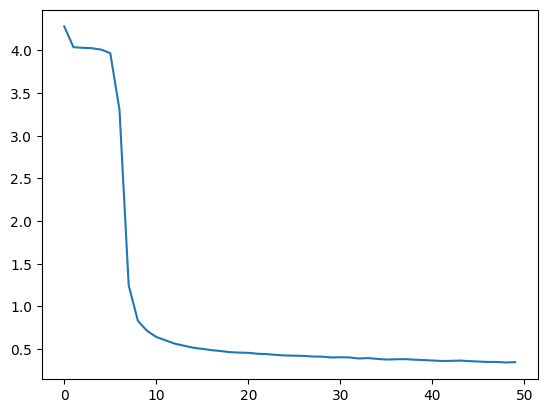

In [204]:
plt.plot(base_metrics["train_loss"])

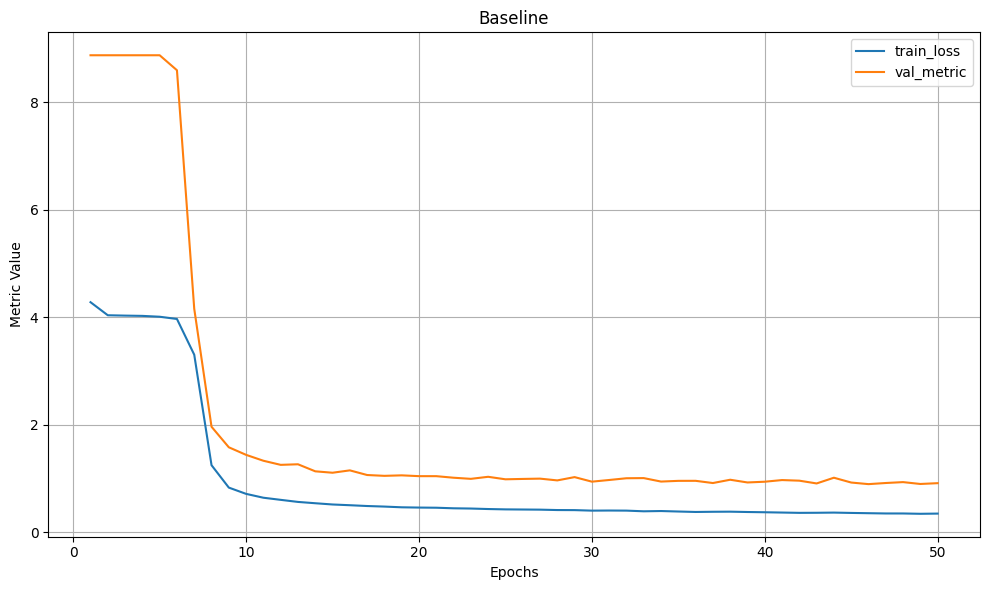

In [210]:
plot_metrics(
    base_metrics,
    "Baseline",
)


In [ ]:
import json

base_model_path = MODELS_DIR / "base_model.pt"

torch.save(base_model.state_dict(), base_model_path)

clean_metrics = {
    key: [float(v) for v in values] for key, values in base_metrics.items()
}

with open(f"{MODELS_DIR}/base_metrics.json", "w") as fd:
    json.dump(clean_metrics, fd)

In [207]:
base_model

ModelBase(
  (conv_part): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(80, 128, kernel_size=(5,), stride=(2,), padding=(2,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
  )
  (rnn_part): Sequential(
    (0): LstmBlock(
      (lstm): LSTM(128, 64, num_layers=2, batch_first=True, bidirectional=True)
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.4, inplace=False)
    )
  )
  (clf): Linear(in_features=128, out_features=46, bias=True)
)

In [ ]:
eval and test_data

### Подготовка

### Функции для обучения модели

In [145]:
def get_vocab(words: pd.Series, blank: str = "<blk>"):
    vocab = {0: blank, 1: "|"}
    all_chars = set("".join(words.astype(str)))

    for i, char in enumerate(sorted(all_chars), start=2):
        vocab[i] = char

    print(f"Vocab is ready, size = {len(vocab)}")
    return vocab

In [146]:
# def path_to_melspect(file_name: str, audio_files_dir: Path = AUDIO_FILES_DIR):
#     wave_form, sr = librosa.load(os.path.join(audio_files_dir, file_name))
#     mel_spectr = librosa.feature.melspectrogram(
#         y=wave_form, sr=sr, n_mels=80, fmax=4096, fmin=0
#     )
#     mel_spectr_db = librosa.power_to_db(mel_spectr, ref=np.max)
#     return mel_spectr_db

In [147]:
def path_to_melspect_cached(
    file_name: str,
    audio_files_dir: Path,
    cache_dir: Path,
    overwrite: bool = False,
) -> np.ndarray:
    cache_path = cache_dir / (file_name.replace(".opus", ".npy"))

    if cache_path.exists() and not overwrite:
        return np.load(cache_path)

    waveform, sr = torchaudio.load(audio_files_dir / file_name)

    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, n_fft=1024, hop_length=256, n_mels=80
    )(waveform)
    mel_db = torchaudio.transforms.AmplitudeToDB(top_db=80)(mel)
    mel_db = mel_db.squeeze(0).cpu().numpy()

    os.makedirs(cache_dir, exist_ok=True)
    np.save(cache_path, mel_db)
    return mel_db


In [ ]:
class Tokenizer:
    def __init__(self, vocab: Dict[int, str]):
        self.index_char = vocab
        self.char_index = {char: index for index, char in self.index_char.items()}

    def __call__(self, chars: Union[str, List[str]]):
        if isinstance(chars, str):
            return [self.char_index.get(char, -1) for char in chars]
        elif isinstance(chars, list):
            return [self.__call__(t) for t in chars]
        else:
            raise ValueError("Expected list or str")

    def decode(self, indexs: Union[List[int], List[List[int]]]):
        if isinstance(indexs, list):
            if isinstance(indexs[0], list):
                return [self.decode(i) for i in indexs]
            else:
                return "".join([self.index_char.get(idx, "") for idx in indexs])
        else:
            raise ValueError("Expected list or str")


In [149]:
def decoding_to_tokens(
    decoder: Callable,
    model_output: torch.Tensor,
    tokenizer: Callable,
):
    log_probs = nn.functional.log_softmax(model_output, dim=-1)
    # print("Log probs shape for beam:", log_probs.shape)
    results = decoder(log_probs.contiguous())  # log_probs: [B, T, C]
    decoded_sequences = []
    for batch_result in results:
        top_hypo = batch_result[0]
        tokens = top_hypo.tokens.tolist()
        # print("Raw Decoder Tokens:", tokens)  # Проверка
        decoded_sequence = tokenizer.decode(tokens)
        decoded_sequence = decoded_sequence.strip("|")
        decoded_sequences.append(decoded_sequence)

    return decoded_sequences

In [ ]:
def loss_ctc(
    model_output: torch.Tensor,  # Тензор [Batch, Time, Classes] - ожидается на device
    targets: torch.Tensor,  # Тензор [sum(target_lengths)] - ожидается на CPU
    target_lengths: torch.Tensor,  # Тензор [B] - ожидается на CPU
    blank_id: int = 0,
) -> torch.Tensor:
    log_output = F.log_softmax(model_output, dim=-1)
    log_output = log_output.transpose(0, 1)

    output_time_dim = log_output.shape[0]  # T'
    batch_size = log_output.shape[1]  # B

    output_lengths = torch.full(
        size=(batch_size,), fill_value=output_time_dim, dtype=torch.long, device="cpu"
    )
    targets_cpu = targets.cpu()
    target_lengths_cpu = target_lengths.cpu()

    loss = nn.CTCLoss(blank=blank_id, reduction="mean", zero_infinity=True)

    batch_loss = loss(log_output, targets_cpu, output_lengths, target_lengths_cpu)
    return batch_loss

In [ ]:
class MorseDataset(Dataset):
    def __init__(
        self,
        X_filenames: pd.Series,
        y_texts: Optional[pd.Series] = None,
        transform: Optional[Callable] = None,
        tokenizer: Optional[Callable[[str], list]] = None,
    ):
        self.X_filenames = X_filenames.reset_index(drop=True)
        if y_texts is not None:
            self.y_texts = y_texts.reset_index(drop=True)
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.X_filenames)

    def __getitem__(self, idx):
        filename = self.X_filenames[idx]
        mel_features = self.transform(filename)  # [C, T] ([n_mels, time])

        item = {"input": torch.tensor(mel_features, dtype=torch.float)}

        if self.y_texts is not None:
            text = self.y_texts[idx]
            if self.tokenizer:
                target = self.tokenizer(text)
            else:
                raise ValueError("Tokenizer needs for target encoding")
            item["target_text"] = text
            item["target"] = torch.tensor(target, dtype=torch.long)
            item["target_length"] = len(target)

        return item

In [ ]:
def dataloader_collate(batch):
    inputs = [item["input"].T for item in batch]  # [T, C]

    padded_inputs = pad_sequence(inputs, batch_first=True)  # [B, max_T, C]
    padded_inputs = padded_inputs.transpose(1, 2)  # [B, C, T]

    collated = {
        "input": padded_inputs,
    }

    if "target" in batch[0]:
        targets = torch.cat(
            [item["target"] for item in batch], dim=0
        )  # склеиваем в 1D тензор
        target_lengths = torch.tensor(
            [item["target_length"] for item in batch], dtype=torch.long
        )
        collated["target_text"] = [item["target_text"] for item in batch]
        collated["target"] = targets
        collated["target_length"] = target_lengths

    return collated


def data_loader(dataset, batch_size, shuffle, num_workers=0, drop_last=True):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=dataloader_collate,
        num_workers=num_workers,
        drop_last=drop_last,
        pin_memory=True,
    )

In [154]:
# from torch.amp import autocast, GradScaler

# scaler = GradScaler()

In [ ]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    ctc_loss: Callable,
    epochs: int,
    metric: Callable,
    decoder: Callable,
    tokenizer: Callable,
    val_loader: Union[DataLoader, None] = None,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device, non_blocking=True)
    metrics = {"train_loss": [], "train_metric": [], "val_metric": []}

    for epoch in range(epochs):
        print(f"\n Epoch {epoch + 1}/{epochs}")
        epoch_loss = []
        # epoch_train_metrics = []
        model.train()
        with tqdm(
            train_loader, desc="Training", total=len(train_loader), dynamic_ncols=True
        ) as pbar:
            for batch in pbar:
                inputs = batch["input"].to(device, non_blocking=True)  # (B, C, T)
                targets = batch["target"]  # (sum_target_len,)
                target_lengths = batch["target_length"]  # (B,)
                # target_text = batch["target_text"]
                optimizer.zero_grad()

                # with autocast(device_type=device.type):
                output = model(inputs)
                loss = ctc_loss(output, targets, target_lengths)

                # scaler.scale(loss).backward()
                # scaler.step(optimizer)
                # scaler.update()
                loss.backward()
                optimizer.step()
                epoch_loss.append(loss.item())

        # emissions = output.detach().cpu().float()
        # tokens_output = decoding_to_tokens(decoder, emissions, tokenizer)
        # batch_train_metrics = [
        #     metric(pred, gt) for pred, gt in zip(tokens_output, target_text)
        # ]
        probss = torch.nn.functional.softmax(output, dim=-1)  #!
        print("avg max prob:", probss.max(dim=-1).values.mean().item())  #!
        # print(probss.shape, probss) #!
        # epoch_train_metrics.append(np.mean(batch_train_metrics))

        avg_epoch_loss = np.mean(epoch_loss)
        # avg_epoch_train_metric = np.mean(epoch_train_metrics)
        metrics["train_loss"].append(avg_epoch_loss)
        # metrics["train_metric"].append(avg_epoch_train_metric)
        print(
            f"Epoch {epoch + 1} with loss = {avg_epoch_loss:.4f}"  # and metric_train={avg_epoch_train_metric:.4f}"
        )

        if val_loader is not None:
            model.eval()
            epoch_val_metrics = []

            with torch.no_grad():
                for batch in tqdm(
                    val_loader, desc=f"Validation Epoch {epoch + 1}", leave=False
                ):
                    inputs = batch["input"].to(device, non_blocking=True)  # (B, C, T)
                    target_text = batch["target_text"]
                    # with autocast(device_type=device.type):
                    predictions = model(inputs)

                    emissions = predictions.detach().cpu().float()
                    pred_indices = predictions.argmax(dim=-1).cpu()

                    tokens_output = decoding_to_tokens(decoder, emissions, tokenizer)

                    batch_val_metrics = [
                        metric(pred, gt) for pred, gt in zip(tokens_output, target_text)
                    ]
                    epoch_val_metrics.append(np.mean(batch_val_metrics))
            # ------------------------------------------------
            for i in range(min(2, len(target_text))):
                print(f"GT        : {target_text[i]}")
                print(f"Argmax    : {tokenizer.decode(pred_indices[i].tolist())}")
                print(f"Beam      : {tokens_output[i]}")  # первые 20 токенов
                print("Argmax:", predictions[i].argmax(-1).tolist()[:20])
            probss = torch.nn.functional.softmax(predictions, dim=-1)
            print("avg max prob:", probss.max(dim=-1).values.mean().item())
            # print(probss.shape, probss)
            # break---------------------------

            avg_epoch_val_metrics = np.mean(epoch_val_metrics)
            metrics["val_metric"].append(avg_epoch_val_metrics)
            print(f"Val Metric={avg_epoch_val_metrics:.4f}")

        else:
            metrics["val_metric"].append(None)

    return model, metrics

In [173]:
class ConvBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, padding, stride=1, groups=1
    ):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding=padding,
            stride=stride,
            groups=groups,
        )
        self.norm = nn.LayerNorm(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x.transpose(1, 2)).transpose(1, 2)
        return self.relu(x)


class LstmBlock(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,  # CNN_out_channels
            hidden_size=hidden_size,  # 256
            num_layers=2,
            bidirectional=True,
            batch_first=True,
        )
        self.norm = nn.LayerNorm(hidden_size * 2)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.drop(self.norm(x))
        return x


In [ ]:
class ModelBase(nn.Module):
    def __init__(
        self,
        input_size: Tuple[int, int],
        kernel_chanel: int,
        conv_out_size: int,
        vocab_size: int,
    ):
        super().__init__()

        self.conv_part = nn.Sequential(
            ConvBlock(
                in_channels=input_size[0],
                out_channels=kernel_chanel,
                kernel_size=5,
                padding=2,
                stride=2,
            ),
            #     # ConvBlock(
            #     #     in_channels=kernel_chanel,
            #     #     out_channels=kernel_chanel,
            #     #     kernel_size=3,
            #     #     padding=1,
            #     # ),
            #     ConvBlock(
            #         in_channels=kernel_chanel,
            #         out_channels=conv_out_size,
            #         kernel_size=3,
            #         padding=0,
            #     ),
        )

        self.rnn_part = nn.Sequential(
            LstmBlock(
                input_size=kernel_chanel, hidden_size=64, dropout=0.4
            ),  # 128, conv_out_size
            # LstmBlock(input_size=128 * 2, hidden_size=64, dropout=0.4),
        )

        self.clf = nn.Linear(
            in_features=64 * 2,
            out_features=vocab_size,
        )

    def forward(self, x):
        x = self.conv_part(x)
        x = x.transpose(1, 2)
        x = self.rnn_part(x)
        return self.clf(x)


: 